<h1>MODEL TESTER WITH GRAD-CAMS</h1>

<h2>Loading dependencies, data, and the trained model</h2>

In [1]:
#LOAD DEPENDENCIES
import os
import cv2
import time
import pickle
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#LOAD THE DATA
train_data_dir = "data/train/"
validation_data_dir = "data/val/"
test_data_dir = "data/test/"

img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
batch_size = 8

print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [3]:
#DATA GENERATORS
val_datagen = ImageDataGenerator(rescale = 1. / 255)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['0_normal', 
                 '1_ulcerative_colitis', 
                 '2_polyps', 
                 '3_esophagitis'])

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['0_normal', 
                 '1_ulcerative_colitis', 
                 '2_polyps', 
                 '3_esophagitis'])

#CHECK  THE NUMBER OF SAMPLES
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print("Validation samples:", nb_validation_samples)
print("Test samples:", nb_test_samples)

if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_test_samples == 0:
    print("NO DATA TEST FOUND! Please check your test data path and folders!")
    print("Check the data folders first!")
else:
    print("Test samples found!")

#check the class indices
validation_generator.class_indices
test_generator.class_indices

#true labels
Y_test=validation_generator.classes
test_labels = test_generator.classes

num_classes= len(validation_generator.class_indices)

print('Model set to train', num_classes, 'classes')

if nb_validation_samples and nb_test_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Validation samples: 2000
Test samples: 800
Validation samples found!
Test samples found!
Model set to train 4 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [4]:
#Load the model to evaluate

structure = ['MFuRe', 'MFNR']
dropout = ['alpha', 'standard', 'no']

#JUST CHANGE THE VALUE HERE TO EITHER 0 or 1 for structure
architecture = structure[0]

#JUST CHANGE THE VALUE HERE TO EITHER 0, 1, or 2 for dropout settings
condition = dropout[0] 

model = load_model('models/' + architecture + 'CNN' + '_'+ condition + '_do/' + 'model.h5')
print("The model is loaded")

model._name = architecture + 'CNN' + '_'+ condition + '_do'
model.summary()

The model is loaded
Model: "MFuReCNN_alpha_do"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_DCNN_A_DCNN_B_DCNN_C_DC [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1_DCNN_A (Rescaling)  (None, 224, 224, 3)  0           input_1_DCNN_A_DCNN_B_DCNN_C_DCNN
__________________________________________________________________________________________________
normalization_1_DCNN_A (Normali (None, 224, 224, 3)  7           rescaling_1_DCNN_A[0][0]         
__________________________________________________________________________________________________
stem_conv_pad_DCNN_A (ZeroPaddi (None, 225, 225, 3)  0           normalization_1_DCNN_A[0][0]     
______________________________________________________________

<h2>Sanity Checker</h2>

In [5]:
#REVIEW THE MODEL YOU ARE CHECKING

print("The model you are to check is the", model._name)

The model you are to check is the MFuReCNN_alpha_do


In [6]:
model.evaluate(validation_generator, return_dict=True)

250/250 [==============================] - 17s 52ms/step - loss: 0.1318 - accuracy: 0.9665


{'loss': 0.13177506625652313, 'accuracy': 0.9664999842643738}

In [7]:
model.evaluate(test_generator, return_dict=True)

100/100 [==============================] - 5s 51ms/step - loss: 0.0922 - accuracy: 0.9775


{'loss': 0.09215529263019562, 'accuracy': 0.9775000214576721}

Prediction: Normal
Confidence: 89%


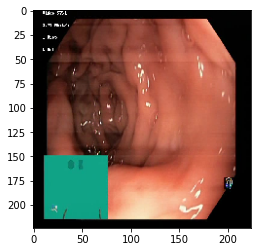

Prediction: Normal
Confidence: 100%


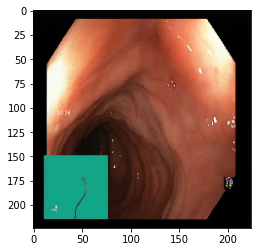

Prediction: Normal
Confidence: 100%


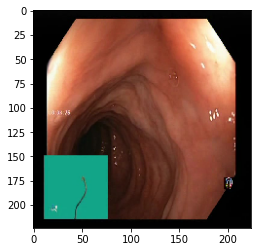

Prediction: Normal
Confidence: 100%


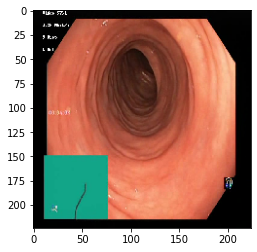

Prediction: Normal
Confidence: 100%


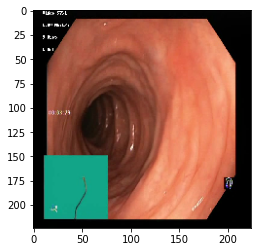

Prediction: Normal
Confidence: 100%


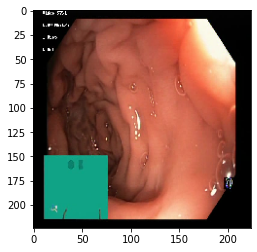

Prediction: Normal
Confidence: 100%


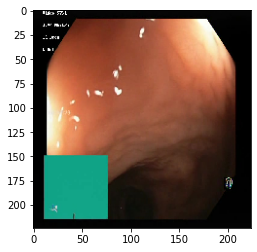

Prediction: Normal
Confidence: 100%


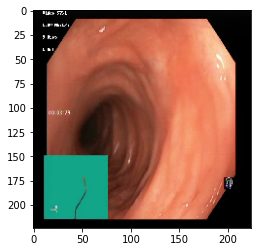

Prediction: Normal
Confidence: 100%


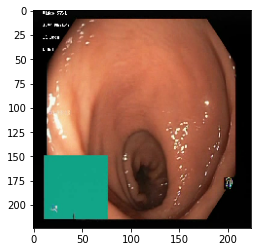

Prediction: Normal
Confidence: 98%


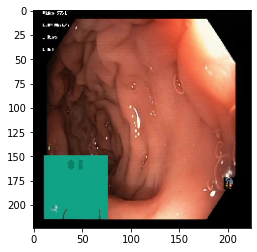

In [8]:
#Test a random sample from either the test dataset or validation dataset
#prediction order: 0-normal, 1-ulcer, 2-polyp, 3-esophagitis

#NO NEED TO CHANGE ANYTHING THIS PREDICTS FROM RANDOM

from random import randint
samples_to_test = 10
dataset_source = [test_generator, validation_generator]

label_dict = {0: 'Normal',
              1: 'Ulcer',
              2: 'Polyp',
              3: 'Esophaghitis'}

#KEEP THE `dataset_source[0]` to `0` to get from the test_generator or test dataset.
for _ in range(samples_to_test):
    img, label = dataset_source[0].next() 
    preds = model.predict(img)
    preds = np.argmax(preds[0])
    score = max(model.predict(img)[0]) * 100
    print("Prediction:", label_dict[preds])
    print("Confidence:", str(round(score)) + '%')
    plt.imshow(img[randint(0, 4)])
    plt.show()

<h2>Grad-CAM preparation</h2>

In [9]:
#Make sure to get the CORRECT Layer for the Grad-CAM depending on the model.
print("The model you are to check is the", model._name)

#MFRN uses the 'FusionLayer' or 'InitialFusionLayer'
#MFuRe uses the 'ResidualFusionLayer' or 'FuRB'

last_conv_layer_name = model.layers[-4].name
print(last_conv_layer_name)

The model you are to check is the MFuReCNN_alpha_do
ResidualFusionLayer


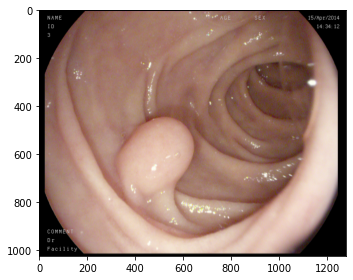

In [10]:
from tensorflow.keras.preprocessing import image

image_format = '.tiff'
dpi = 300

a = 'normal'
b = 'ulcer'
c = 'polyp'
d = 'esophagitis'

###JUST CHANGE ONLY THIS VALUE TO CHECK OTHER CASES.

case = c

###################################

img_path = 'test_samples/' + case + '.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = cv2.resize(x, (224, 224)) 
x = x / 255.0
x = np.expand_dims(x, axis=0)
plt.tight_layout()
plt.savefig('gradcam/' + architecture + 'CNN' + '_'+ condition + '_do/' + case +'-0-original' + image_format, dpi=dpi)

In [11]:
#Prediciton Checker
gradcam_preds = model.predict(x)
gradcam_preds = np.argmax(gradcam_preds[0])
grad_score = max(model.predict(x)[0] * 100)
print("Prediction:", label_dict[gradcam_preds])
print("Confidence:", str(round(grad_score)) + '%')

Prediction: Polyp
Confidence: 98%


In [12]:
#Generation of heatmap
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

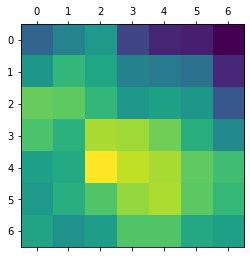

In [13]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(x)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.savefig('gradcam/' + architecture + 'CNN' + '_'+ condition + '_do/' + case + '-1-heatmap' + image_format, dpi=dpi)
plt.show()

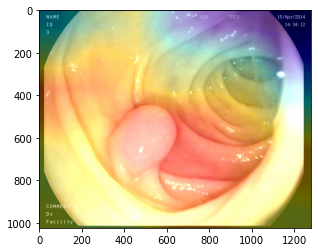

In [14]:
#Output the super imposed image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
plt.tight_layout()
save_img_path = 'gradcam/' + architecture + 'CNN' + '_'+ condition + '_do/' + case + '-2-gradcam' + '.jpg'

cv2.imwrite(save_img_path, superimposed_img)

img1 = image.load_img(save_img_path)
plt.imshow(img1);